In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/WS_2000_4_03.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.48, 0.50, 0.52, 0.54, 0.56, 0.58, 0.60, \
         0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80,\
         0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
i_beta_22_08 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 100    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 0.8
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 0))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_22_08[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 27.01099920272827 
    loop_MC 1 - time has passed: 51.91899800300598 
    loop_MC 2 - time has passed: 77.7969982624054 
    loop_MC 3 - time has passed: 105.62700605392456 
    loop_MC 4 - time has passed: 131.9009976387024 
    loop_MC 5 - time has passed: 157.6219983100891 
    loop_MC 6 - time has passed: 183.26299905776978 
    loop_MC 7 - time has passed: 209.27399897575378 
    loop_MC 8 - time has passed: 235.06299829483032 
    loop_MC 9 - time has passed: 260.6219973564148 
    loop_MC 10 - time has passed: 285.26399850845337 
    loop_MC 11 - time has passed: 309.90799832344055 
    loop_MC 12 - time has passed: 334.9640140533447 
    loop_MC 13 - time has passed: 359.93899846076965 
    loop_MC 14 - time has passed: 385.6910083293915 
    loop_MC 15 - time has passed: 411.2239992618561 
    loop_MC 16 - time has passed: 436.67299818992615 
    loop_MC 17 - time has passed: 462.16899824142456 
    loop_MC 18 - time has passed: 487.3399975299

    loop_MC 54 - time has passed: 1370.2580008506775 
    loop_MC 55 - time has passed: 1395.8440012931824 
    loop_MC 56 - time has passed: 1421.6200008392334 
    loop_MC 57 - time has passed: 1447.219001531601 
    loop_MC 58 - time has passed: 1472.1240003108978 
    loop_MC 59 - time has passed: 1497.1550014019012 
    loop_MC 60 - time has passed: 1521.6440000534058 
    loop_MC 61 - time has passed: 1546.0670013427734 
    loop_MC 62 - time has passed: 1571.1420001983643 
    loop_MC 63 - time has passed: 1596.535001039505 
    loop_MC 64 - time has passed: 1621.8100011348724 
    loop_MC 65 - time has passed: 1646.561000585556 
    loop_MC 66 - time has passed: 1671.7590007781982 
    loop_MC 67 - time has passed: 1696.3640015125275 
    loop_MC 68 - time has passed: 1720.6980016231537 
    loop_MC 69 - time has passed: 1745.3720002174377 
    loop_MC 70 - time has passed: 1769.9970152378082 
    loop_MC 71 - time has passed: 1794.9080004692078 
    loop_MC 72 - time has passe

    loop_MC 6 - time has passed: 176.87500095367432 
    loop_MC 7 - time has passed: 201.75900053977966 
    loop_MC 8 - time has passed: 226.7629997730255 
    loop_MC 9 - time has passed: 251.22300004959106 
    loop_MC 10 - time has passed: 276.8550000190735 
    loop_MC 11 - time has passed: 302.18600058555603 
    loop_MC 12 - time has passed: 327.00400161743164 
    loop_MC 13 - time has passed: 351.86900091171265 
    loop_MC 14 - time has passed: 376.73600029945374 
    loop_MC 15 - time has passed: 401.7519998550415 
    loop_MC 16 - time has passed: 426.6760005950928 
    loop_MC 17 - time has passed: 451.71099972724915 
    loop_MC 18 - time has passed: 477.07000041007996 
    loop_MC 19 - time has passed: 502.00300192832947 
    loop_MC 20 - time has passed: 527.1700296401978 
    loop_MC 21 - time has passed: 552.3830018043518 
    loop_MC 22 - time has passed: 576.9809997081757 
    loop_MC 23 - time has passed: 601.262020111084 
    loop_MC 24 - time has passed: 625.732

    loop_MC 59 - time has passed: 1516.3489563465118 
    loop_MC 60 - time has passed: 1542.2009553909302 
    loop_MC 61 - time has passed: 1567.8999540805817 
    loop_MC 62 - time has passed: 1592.8679707050323 
    loop_MC 63 - time has passed: 1618.0159537792206 
    loop_MC 64 - time has passed: 1643.3619546890259 
    loop_MC 65 - time has passed: 1668.5829560756683 
    loop_MC 66 - time has passed: 1693.655956029892 
    loop_MC 67 - time has passed: 1718.9739546775818 
    loop_MC 68 - time has passed: 1744.112954378128 
    loop_MC 69 - time has passed: 1769.677976846695 
    loop_MC 70 - time has passed: 1795.1049547195435 
    loop_MC 71 - time has passed: 1820.6919548511505 
    loop_MC 72 - time has passed: 1845.490021944046 
    loop_MC 73 - time has passed: 1870.0839540958405 
    loop_MC 74 - time has passed: 1894.8069548606873 
    loop_MC 75 - time has passed: 1920.197954416275 
    loop_MC 76 - time has passed: 1945.423954486847 
    loop_MC 77 - time has passed: 

    loop_MC 11 - time has passed: 301.36844515800476 
    loop_MC 12 - time has passed: 327.05774760246277 
    loop_MC 13 - time has passed: 352.62855410575867 
    loop_MC 14 - time has passed: 377.5761933326721 
    loop_MC 15 - time has passed: 402.79431438446045 
    loop_MC 16 - time has passed: 427.55220675468445 
    loop_MC 17 - time has passed: 452.6244468688965 
    loop_MC 18 - time has passed: 477.5220501422882 
    loop_MC 19 - time has passed: 502.2143611907959 
    loop_MC 20 - time has passed: 527.3687520027161 
    loop_MC 21 - time has passed: 552.6207506656647 
    loop_MC 22 - time has passed: 577.6931531429291 
    loop_MC 23 - time has passed: 602.6013317108154 
    loop_MC 24 - time has passed: 627.4237613677979 
    loop_MC 25 - time has passed: 652.221821308136 
    loop_MC 26 - time has passed: 677.1592552661896 
    loop_MC 27 - time has passed: 702.0824847221375 
    loop_MC 28 - time has passed: 727.5555284023285 
    loop_MC 29 - time has passed: 752.9974

    loop_MC 64 - time has passed: 1661.2650077342987 
    loop_MC 65 - time has passed: 1686.5442838668823 
    loop_MC 66 - time has passed: 1711.282378911972 
    loop_MC 67 - time has passed: 1736.396235704422 
    loop_MC 68 - time has passed: 1762.5204634666443 
    loop_MC 69 - time has passed: 1788.4038071632385 
    loop_MC 70 - time has passed: 1814.2193052768707 
    loop_MC 71 - time has passed: 1839.857097864151 
    loop_MC 72 - time has passed: 1865.5092120170593 
    loop_MC 73 - time has passed: 1891.3810119628906 
    loop_MC 74 - time has passed: 1917.0109944343567 
    loop_MC 75 - time has passed: 1942.5216779708862 
    loop_MC 76 - time has passed: 1968.020441532135 
    loop_MC 77 - time has passed: 1993.4928681850433 
    loop_MC 78 - time has passed: 2018.7231817245483 
    loop_MC 79 - time has passed: 2044.1240463256836 
    loop_MC 80 - time has passed: 2069.2261080741882 
    loop_MC 81 - time has passed: 2094.344936609268 
    loop_MC 82 - time has passed:

    loop_MC 16 - time has passed: 423.7661681175232 
    loop_MC 17 - time has passed: 448.92616605758667 
    loop_MC 18 - time has passed: 474.427166223526 
    loop_MC 19 - time has passed: 499.66816568374634 
    loop_MC 20 - time has passed: 524.7051923274994 
    loop_MC 21 - time has passed: 549.4071667194366 
    loop_MC 22 - time has passed: 574.0951669216156 
    loop_MC 23 - time has passed: 599.1701867580414 
    loop_MC 24 - time has passed: 623.7071723937988 
    loop_MC 25 - time has passed: 648.5171666145325 
    loop_MC 26 - time has passed: 673.2091658115387 
    loop_MC 27 - time has passed: 698.1621658802032 
    loop_MC 28 - time has passed: 722.9641742706299 
    loop_MC 29 - time has passed: 747.7151663303375 
    loop_MC 30 - time has passed: 772.752210855484 
    loop_MC 31 - time has passed: 797.7041673660278 
    loop_MC 32 - time has passed: 822.7071671485901 
    loop_MC 33 - time has passed: 847.8121662139893 
    loop_MC 34 - time has passed: 872.81736636

    loop_MC 69 - time has passed: 1753.2044241428375 
    loop_MC 70 - time has passed: 1778.2124252319336 
    loop_MC 71 - time has passed: 1803.2784237861633 
    loop_MC 72 - time has passed: 1828.331425666809 
    loop_MC 73 - time has passed: 1853.3334639072418 
    loop_MC 74 - time has passed: 1878.4694244861603 
    loop_MC 75 - time has passed: 1903.1954255104065 
    loop_MC 76 - time has passed: 1927.867425918579 
    loop_MC 77 - time has passed: 1952.5385222434998 
    loop_MC 78 - time has passed: 1977.066484928131 
    loop_MC 79 - time has passed: 2001.6684246063232 
    loop_MC 80 - time has passed: 2026.2814242839813 
    loop_MC 81 - time has passed: 2050.667424440384 
    loop_MC 82 - time has passed: 2075.311425924301 
    loop_MC 83 - time has passed: 2100.2144405841827 
    loop_MC 84 - time has passed: 2125.1854243278503 
    loop_MC 85 - time has passed: 2149.621424436569 
    loop_MC 86 - time has passed: 2174.287424325943 
    loop_MC 87 - time has passed: 2

    loop_MC 21 - time has passed: 546.3761982917786 
    loop_MC 22 - time has passed: 571.7061946392059 
    loop_MC 23 - time has passed: 596.8491942882538 
    loop_MC 24 - time has passed: 621.4011960029602 
    loop_MC 25 - time has passed: 646.3111946582794 
    loop_MC 26 - time has passed: 671.7091953754425 
    loop_MC 27 - time has passed: 697.1641931533813 
    loop_MC 28 - time has passed: 722.3332707881927 
    loop_MC 29 - time has passed: 747.0492360591888 
    loop_MC 30 - time has passed: 772.3781940937042 
    loop_MC 31 - time has passed: 797.8081941604614 
    loop_MC 32 - time has passed: 822.9192061424255 
    loop_MC 33 - time has passed: 848.5701954364777 
    loop_MC 34 - time has passed: 873.7251942157745 
    loop_MC 35 - time has passed: 898.1751945018768 
    loop_MC 36 - time has passed: 923.3722050189972 
    loop_MC 37 - time has passed: 948.7081933021545 
    loop_MC 38 - time has passed: 974.267195224762 
    loop_MC 39 - time has passed: 999.373850345

    loop_MC 74 - time has passed: 1872.3868534564972 
    loop_MC 75 - time has passed: 1897.193858385086 
    loop_MC 76 - time has passed: 1921.4948091506958 
    loop_MC 77 - time has passed: 1946.1638116836548 
    loop_MC 78 - time has passed: 1971.3698110580444 
    loop_MC 79 - time has passed: 1996.8568131923676 
    loop_MC 80 - time has passed: 2022.0358283519745 
    loop_MC 81 - time has passed: 2047.2300288677216 
    loop_MC 82 - time has passed: 2072.683030128479 
    loop_MC 83 - time has passed: 2097.8340742588043 
    loop_MC 84 - time has passed: 2122.588044643402 
    loop_MC 85 - time has passed: 2147.40202999115 
    loop_MC 86 - time has passed: 2171.9830298423767 
    loop_MC 87 - time has passed: 2196.7460310459137 
    loop_MC 88 - time has passed: 2221.4850294589996 
    loop_MC 89 - time has passed: 2247.066091299057 
    loop_MC 90 - time has passed: 2272.325030565262 
    loop_MC 91 - time has passed: 2297.9830298423767 
    loop_MC 92 - time has passed: 2

    loop_MC 27 - time has passed: 702.7042498588562 
    loop_MC 28 - time has passed: 727.5042407512665 
    loop_MC 29 - time has passed: 752.2112400531769 
    loop_MC 30 - time has passed: 777.2912476062775 
    loop_MC 31 - time has passed: 802.2852401733398 
    loop_MC 32 - time has passed: 827.204240322113 
    loop_MC 33 - time has passed: 852.299239397049 
    loop_MC 34 - time has passed: 877.7212421894073 
    loop_MC 35 - time has passed: 902.9982392787933 
    loop_MC 36 - time has passed: 927.6852395534515 
    loop_MC 37 - time has passed: 952.8582491874695 
    loop_MC 38 - time has passed: 978.2425124645233 
    loop_MC 39 - time has passed: 1002.9115080833435 
    loop_MC 40 - time has passed: 1027.8324875831604 
    loop_MC 41 - time has passed: 1052.7314977645874 
    loop_MC 42 - time has passed: 1077.8424978256226 
    loop_MC 43 - time has passed: 1102.7144873142242 
    loop_MC 44 - time has passed: 1127.8414988517761 
    loop_MC 45 - time has passed: 1153.311

    loop_MC 80 - time has passed: 2048.6748259067535 
    loop_MC 81 - time has passed: 2073.645827770233 
    loop_MC 82 - time has passed: 2099.019826412201 
    loop_MC 83 - time has passed: 2124.307868003845 
    loop_MC 84 - time has passed: 2149.766003847122 
    loop_MC 85 - time has passed: 2175.249011993408 
    loop_MC 86 - time has passed: 2200.485003232956 
    loop_MC 87 - time has passed: 2225.7030045986176 
    loop_MC 88 - time has passed: 2250.930054664612 
    loop_MC 89 - time has passed: 2275.812029838562 
    loop_MC 90 - time has passed: 2300.4560384750366 
    loop_MC 91 - time has passed: 2325.1470024585724 
    loop_MC 92 - time has passed: 2350.0020051002502 
    loop_MC 93 - time has passed: 2374.84100317955 
    loop_MC 94 - time has passed: 2400.256003141403 
    loop_MC 95 - time has passed: 2425.517003297806 
    loop_MC 96 - time has passed: 2450.9020030498505 
    loop_MC 97 - time has passed: 2476.3590042591095 
    loop_MC 98 - time has passed: 2501.5

    loop_MC 33 - time has passed: 854.1952166557312 
    loop_MC 34 - time has passed: 879.2122187614441 
    loop_MC 35 - time has passed: 904.3452191352844 
    loop_MC 36 - time has passed: 929.5452182292938 
    loop_MC 37 - time has passed: 954.6262173652649 
    loop_MC 38 - time has passed: 979.3282260894775 
    loop_MC 39 - time has passed: 1004.0482182502747 
    loop_MC 40 - time has passed: 1029.4223976135254 
    loop_MC 41 - time has passed: 1053.9773967266083 
    loop_MC 42 - time has passed: 1078.632396221161 
    loop_MC 43 - time has passed: 1103.8023958206177 
    loop_MC 44 - time has passed: 1128.9633979797363 
    loop_MC 45 - time has passed: 1153.9803974628448 
    loop_MC 46 - time has passed: 1179.1524062156677 
    loop_MC 47 - time has passed: 1204.055396080017 
    loop_MC 48 - time has passed: 1229.1763970851898 
    loop_MC 49 - time has passed: 1254.6283977031708 
    loop_MC 50 - time has passed: 1280.1623976230621 
    loop_MC 51 - time has passed: 13

    loop_MC 86 - time has passed: 2188.450277328491 
    loop_MC 87 - time has passed: 2212.945508956909 
    loop_MC 88 - time has passed: 2237.707499265671 
    loop_MC 89 - time has passed: 2262.528670310974 
    loop_MC 90 - time has passed: 2287.1326694488525 
    loop_MC 91 - time has passed: 2311.923202753067 
    loop_MC 92 - time has passed: 2336.7161605358124 
    loop_MC 93 - time has passed: 2362.243177652359 
    loop_MC 94 - time has passed: 2386.7852079868317 
    loop_MC 95 - time has passed: 2412.0511603355408 
    loop_MC 96 - time has passed: 2436.633160352707 
    loop_MC 97 - time has passed: 2461.24116063118 
    loop_MC 98 - time has passed: 2485.823162317276 
    loop_MC 99 - time has passed: 2511.5851628780365 
loop_b 19 - time has passed: 50173.098947286606 
    loop_MC 0 - time has passed: 25.001002311706543 
    loop_MC 1 - time has passed: 49.6240017414093 
    loop_MC 2 - time has passed: 74.12500023841858 
    loop_MC 3 - time has passed: 98.6890432834625

    loop_MC 39 - time has passed: 1003.0808312892914 
    loop_MC 40 - time has passed: 1029.1408970355988 
    loop_MC 41 - time has passed: 1054.619869709015 
    loop_MC 42 - time has passed: 1079.1358313560486 
    loop_MC 43 - time has passed: 1103.8988831043243 
    loop_MC 44 - time has passed: 1129.8358316421509 
    loop_MC 45 - time has passed: 1155.9258320331573 
    loop_MC 46 - time has passed: 1181.5518486499786 
    loop_MC 47 - time has passed: 1206.823830127716 
    loop_MC 48 - time has passed: 1232.1428327560425 
    loop_MC 49 - time has passed: 1257.7468311786652 
    loop_MC 50 - time has passed: 1283.4128322601318 
    loop_MC 51 - time has passed: 1309.0128509998322 
    loop_MC 52 - time has passed: 1334.425836801529 
    loop_MC 53 - time has passed: 1360.3398306369781 
    loop_MC 54 - time has passed: 1385.9658291339874 
    loop_MC 55 - time has passed: 1411.606845855713 
    loop_MC 56 - time has passed: 1437.2568316459656 
    loop_MC 57 - time has passed

    loop_MC 92 - time has passed: 2325.27547287941 
    loop_MC 93 - time has passed: 2350.567473888397 
    loop_MC 94 - time has passed: 2376.668473482132 
    loop_MC 95 - time has passed: 2402.6014726161957 
    loop_MC 96 - time has passed: 2428.0194730758667 
    loop_MC 97 - time has passed: 2453.2765140533447 
    loop_MC 98 - time has passed: 2478.2374732494354 
    loop_MC 99 - time has passed: 2502.9954714775085 
loop_b 22 - time has passed: 57689.12962722778 
    loop_MC 0 - time has passed: 25.01500129699707 
    loop_MC 1 - time has passed: 50.23601698875427 
    loop_MC 2 - time has passed: 75.86200094223022 
    loop_MC 3 - time has passed: 101.32001781463623 
    loop_MC 4 - time has passed: 125.90000224113464 
    loop_MC 5 - time has passed: 151.33200192451477 
    loop_MC 6 - time has passed: 176.4350185394287 
    loop_MC 7 - time has passed: 200.96300196647644 
    loop_MC 8 - time has passed: 225.31100153923035 
    loop_MC 9 - time has passed: 249.89900088310242

    loop_MC 44 - time has passed: 1129.8504328727722 
    loop_MC 45 - time has passed: 1155.463440656662 
    loop_MC 46 - time has passed: 1181.1634323596954 
    loop_MC 47 - time has passed: 1206.238482952118 
    loop_MC 48 - time has passed: 1231.7384345531464 
    loop_MC 49 - time has passed: 1257.1327228546143 
    loop_MC 50 - time has passed: 1281.9907233715057 
    loop_MC 51 - time has passed: 1307.0527646541595 
    loop_MC 52 - time has passed: 1331.557722568512 
    loop_MC 53 - time has passed: 1356.118721961975 
    loop_MC 54 - time has passed: 1380.783724784851 
    loop_MC 55 - time has passed: 1406.207721710205 
    loop_MC 56 - time has passed: 1430.7527225017548 
    loop_MC 57 - time has passed: 1455.7527348995209 
    loop_MC 58 - time has passed: 1481.1287233829498 
    loop_MC 59 - time has passed: 1506.652723312378 
    loop_MC 60 - time has passed: 1531.6877226829529 
    loop_MC 61 - time has passed: 1556.49072265625 
    loop_MC 62 - time has passed: 158

    loop_MC 97 - time has passed: 2479.8263037204742 
    loop_MC 98 - time has passed: 2505.1513035297394 
    loop_MC 99 - time has passed: 2529.973303794861 
loop_b 25 - time has passed: 65245.92457294464 
    loop_MC 0 - time has passed: 25.04400324821472 
    loop_MC 1 - time has passed: 50.17100238800049 
    loop_MC 2 - time has passed: 75.55803442001343 
    loop_MC 3 - time has passed: 100.56506037712097 
    loop_MC 4 - time has passed: 125.272052526474 
    loop_MC 5 - time has passed: 150.78100109100342 
    loop_MC 6 - time has passed: 176.20900440216064 
    loop_MC 7 - time has passed: 201.59500217437744 
    loop_MC 8 - time has passed: 227.0010437965393 
    loop_MC 9 - time has passed: 252.6260118484497 
    loop_MC 10 - time has passed: 278.3640019893646 
    loop_MC 11 - time has passed: 304.0250015258789 
    loop_MC 12 - time has passed: 329.78600215911865 
    loop_MC 13 - time has passed: 355.4404318332672 
    loop_MC 14 - time has passed: 380.76243257522583 
 

In [6]:
print(i_beta_22_08)

[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 5.000e-06 2.500e-05 0.000e+00 5.500e-05 2.000e-05 1.000e-05 1.000e-04
 3.500e-05 9.500e-05 2.500e-05 7.000e-05 2.850e-04 1.700e-04 1.900e-04
 2.700e-04 5.800e-04 6.950e-04 4.400e-04 1.260e-03 1.145e-03]


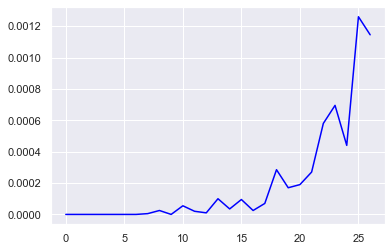

In [7]:
plt.plot(i_beta_22_08, color='blue')

In [8]:
scio.savemat('./i_beta_22_08_new.mat', {'i_beta_22_08': i_beta_22_08})